In [1]:
#pip install tensorflow scikit-learn matplotlib


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json

# Function to apply Canny edge detection
def apply_canny_edge_detection(image):
    image = image.astype('uint8')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges

# Load and preprocess images
def load_and_preprocess_images(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = set()
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as file:
                data = json.load(file)
            for item in data:
                image_path = os.path.join(directory, item['image'])
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=target_size)
                    img_array = img_to_array(img)
                    img_array_canny = apply_canny_edge_detection(img_array)
                    images.extend([img_array, img_array_canny])
                    label = item['annotations'][0]['label']
                    labels.extend([label, label])
                    class_names.add(label)

    images = np.array(images)
    images = tf.keras.applications.efficientnet.preprocess_input(images)
    labels = np.array([list(class_names).index(label) for label in labels])
    return images, labels, list(class_names)

# Directory containing your data
directory = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu'
images, labels, class_names = load_and_preprocess_images(directory)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.2857 - loss: 1.8609 - val_accuracy: 0.3750 - val_loss: 1.7572
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4286 - loss: 1.5945 - val_accuracy: 0.3750 - val_loss: 1.7342
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 1.4402 - val_accuracy: 0.3750 - val_loss: 1.7688
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4643 - loss: 1.3518 - val_accuracy: 0.3750 - val_loss: 1.8318
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 1.1612 - val_accuracy: 0.5000 - val_loss: 1.9274
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6429 - loss: 1.1102 - val_accuracy: 0.5000 - val_loss: 2.0229
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6429 - loss: 1.0085 - val_accuracy: 0.5000 - val_loss: 2.1061
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.9050 - val_accuracy: 0.5000 - val_loss: 2.1763
Epoch 9/20
1/1

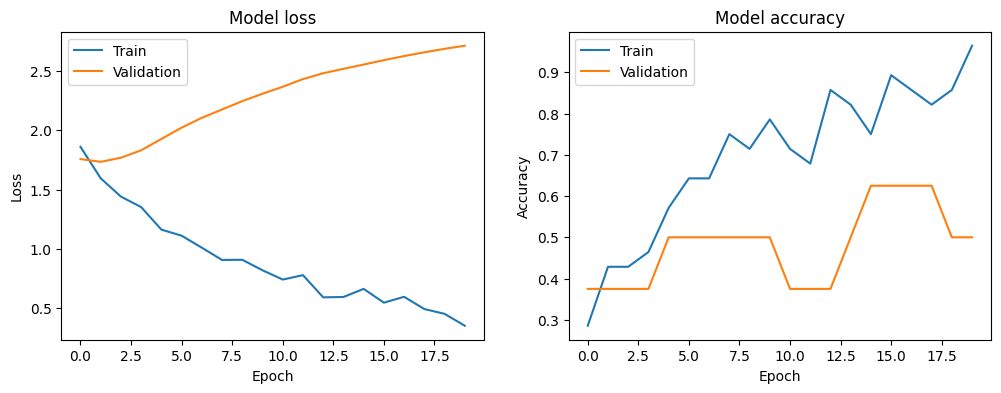

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

def create_model(input_shape, num_classes):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
    from tensorflow.keras.models import Model

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming 'images', 'labels', and 'class_names' are loaded and defined in previous cells
input_shape = (224, 224, 3)
num_classes = len(class_names)
model = create_model(input_shape, num_classes)

# Data augmentation and generators setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

history = model.fit(train_generator, validation_data=val_generator, epochs=20)
model.save(r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet.keras')

# Visualize training history
plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image: test_ahu1.png, Predicted Label: erv_wheel


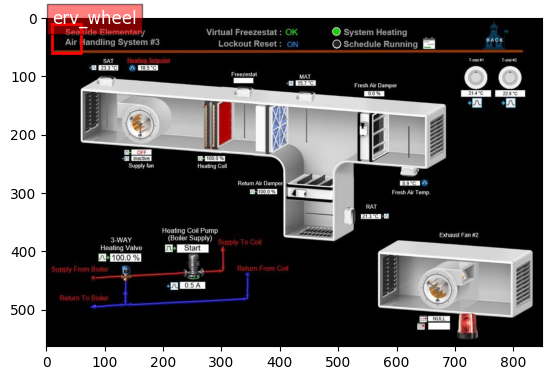

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Image: test_ahu2.png, Predicted Label: erv_wheel


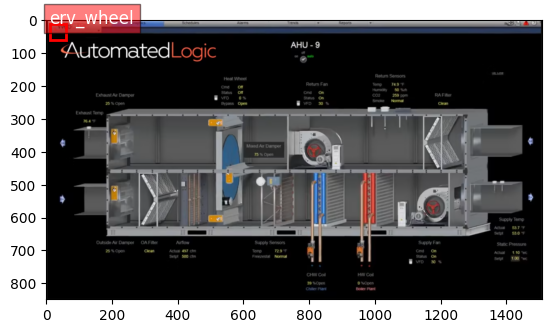

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Image: test_ahu3.png, Predicted Label: erv_wheel


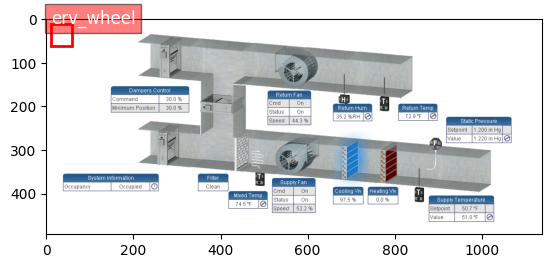

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Image: test_ahu4.png, Predicted Label: damper


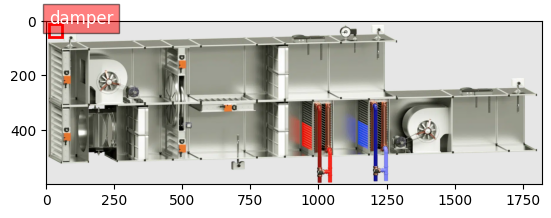

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import tensorflow as tf

def apply_canny_edge_detection(image):
    # Ensure the image is in the right type, scale might still be 0-1 or 0-255
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Convert from 0-1 to 0-255 if necessary

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray, 100, 200)  # Apply Canny edge detection
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
    return edges


def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Make sure the image is in uint8 format before applying Canny edge detection
    img_array = apply_canny_edge_detection(img_array)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # This expects float inputs
    return np.expand_dims(img_array, axis=0)  # Add batch dimension for the model


# Function to display an image with bounding boxes
def display_image_with_boxes(image_path, predicted_label, annotation_data):
    img = load_img(image_path)
    img_array = img_to_array(img) / 255.0  # Normalize to [0,1] for display
    fig, ax = plt.subplots()
    ax.imshow(img_array)

    # Draw bounding boxes from annotation data
    for annotation in annotation_data:
        if annotation['label'] == predicted_label:
            x, y, width, height = annotation['coordinates']
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, annotation['label'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Load the trained model
model_path = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet.keras'
model = tf.keras.models.load_model(model_path)

# Directory containing test images
test_images_dir = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\test_images'

# Predict each image in the test directory
for img_file in os.listdir(test_images_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_images_dir, img_file)
        img_preprocessed = load_and_preprocess_image(img_path)
        predictions = model.predict(img_preprocessed)
        predicted_label = class_names[np.argmax(predictions)]
        print(f"Image: {img_file}, Predicted Label: {predicted_label}")

        # Assuming the annotations are stored in memory
        annotations = [{
            "label": predicted_label, 
            "coordinates": (10, 10, 50, 50)  # Placeholder coordinates
        }]
        
        display_image_with_boxes(img_path, predicted_label, annotations)
